In [210]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data Clean

In [211]:
#load all of the data
raw_data = []
raw_data.append(pd.read_csv('season-0910_csv.csv'))
raw_data.append(pd.read_csv('season-1011_csv.csv'))
raw_data.append(pd.read_csv('season-1112_csv.csv'))
raw_data.append(pd.read_csv('season-1213_csv.csv'))
raw_data.append(pd.read_csv('season-1314_csv.csv'))
raw_data.append(pd.read_csv('season-1415_csv.csv'))
raw_data.append(pd.read_csv('season-1516_csv.csv'))
raw_data.append(pd.read_csv('season-1617_csv.csv'))
raw_data.append(pd.read_csv('season-1718_csv.csv'))
raw_data.append(pd.read_csv('season-1819_csv.csv'))
#merge these data 
dataset = pd.DataFrame()
for i in range(len(raw_data)):
  dataset = dataset.append(raw_data[i], ignore_index = True)

  
columns_req = ['HomeTeam','AwayTeam','FTR','HC','AC','HST','AST','HY','AY','HR','AR']
dataset = dataset[columns_req]

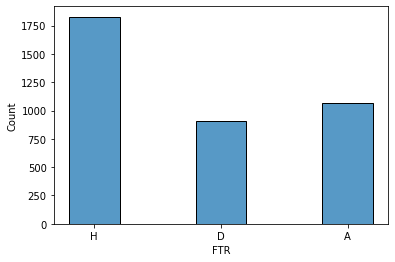

In [212]:
sns.histplot(data = dataset, x="FTR", shrink=.4)#check whether our data is balanced
plt.show()

In [213]:
mapping = {"H":1,"D":0,"A":0}
dataset = dataset.replace(mapping)
dataset = dataset.rename(columns = {"FTR":"whether_home_wins"})

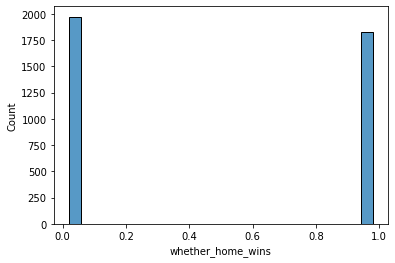

In [214]:
sns.histplot(data = dataset,x="whether_home_wins", shrink=.5) #check now whether it is balanced
plt.show()

In [215]:
dataset

,HomeTeam,AwayTeam,whether_home_wins,HC,AC,HST,AST,HY,AY,HR,AR
0,Real Madrid,La Coruna,1,10,3,11,3,2,2,0,0
1,Zaragoza,Tenerife,1,7,8,8,2,1,4,0,0
2,Almeria,Valladolid,0,12,2,5,1,2,2,0,1
3,Ath Bilbao,Espanol,1,6,3,4,1,2,6,0,0
4,Malaga,Ath Madrid,1,4,5,4,3,4,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3795,Levante,Ath Madrid,0,6,4,7,8,0,1,0,1
3796,Sevilla,Ath Bilbao,1,2,3,3,1,4,2,0,0
3797,Valladolid,Valencia,0,8,2,4,6,1,3,0,0
3798,Eibar,Barcelona,0,5,2,8,3,4,2,0,0


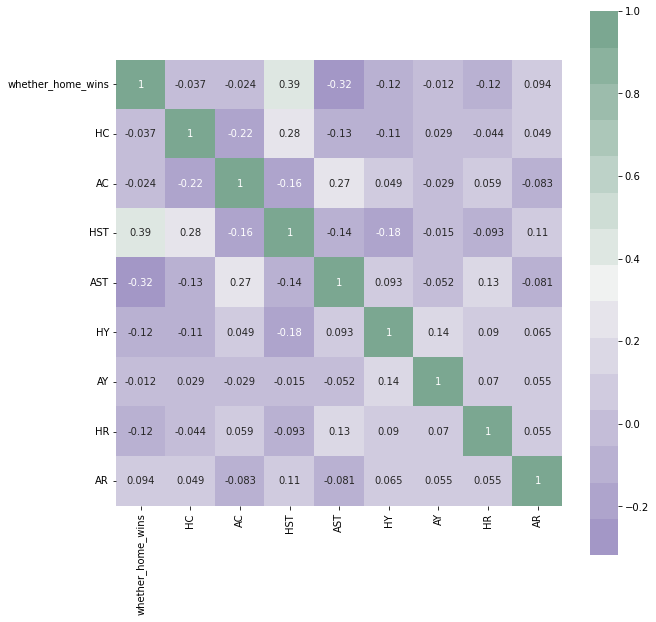

In [216]:
style = sns.diverging_palette(275, 150,  s=40, l=65, n=15)# check whether there is a corelation between target value and input data
plt.figure(figsize=(10,10))
sns.heatmap(dataset.corr(),cmap= style,annot=True, square=True)
plt.show()

In [217]:
dataset.tail()

,HomeTeam,AwayTeam,whether_home_wins,HC,AC,HST,AST,HY,AY,HR,AR
3795,Levante,Ath Madrid,0,6,4,7,8,0,1,0,1
3796,Sevilla,Ath Bilbao,1,2,3,3,1,4,2,0,0
3797,Valladolid,Valencia,0,8,2,4,6,1,3,0,0
3798,Eibar,Barcelona,0,5,2,8,3,4,2,0,0
3799,Real Madrid,Betis,0,1,5,2,7,4,1,0,0


In [218]:
dataset.describe()

,whether_home_wins,HC,AC,HST,AST,HY,AY,HR,AR
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,0.481316,5.962368,4.463421,5.050789,3.882105,2.447105,2.723947,0.124474,0.164474
std,0.499717,2.967651,2.557520,2.669631,2.291887,1.486038,1.509941,0.354761,0.407938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,3.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000
50%,0.000000,6.000000,4.000000,5.000000,4.000000,2.000000,3.000000,0.000000,0.000000
75%,1.000000,8.000000,6.000000,7.000000,5.000000,3.000000,4.000000,0.000000,0.000000
max,1.000000,20.000000,17.000000,18.000000,16.000000,8.000000,9.000000,3.000000,3.000000


In [219]:
dataset.isna().sum() #to find whether there is a null value in the dataset

HomeTeam             0
AwayTeam             0
whether_home_wins    0
HC                   0
AC                   0
HST                  0
AST                  0
HY                   0
AY                   0
HR                   0
AR                   0
dtype: int64

#Data preprocessing

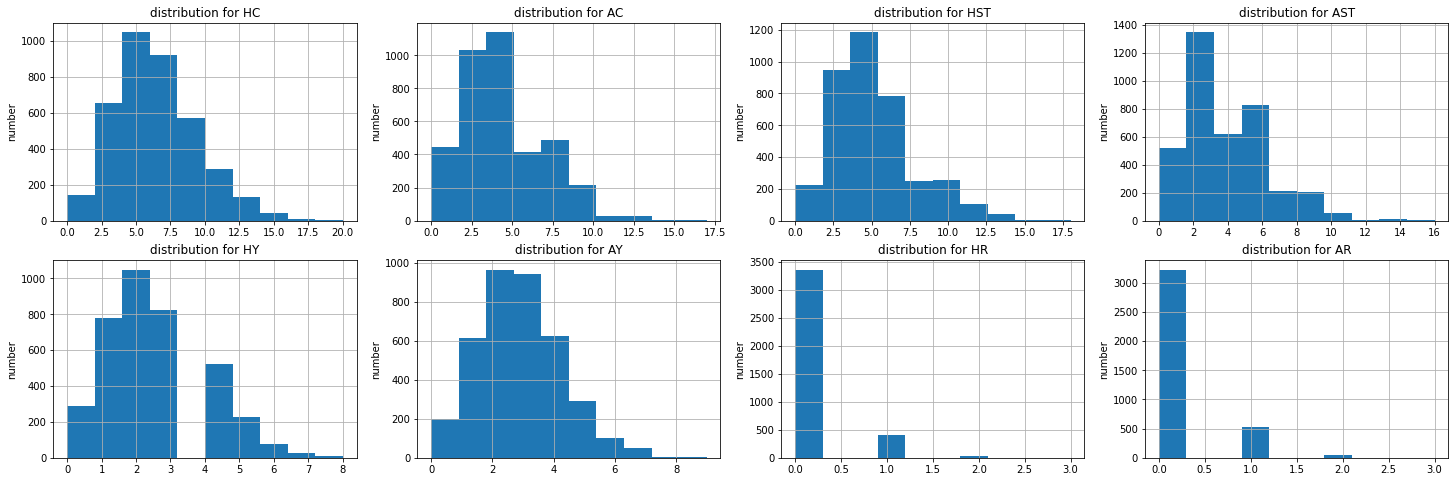

In [220]:
#the distributin visulation of our features
fig = plt.figure(figsize = (25,8))
ax1 = fig.add_subplot(2,4,1)
ax1.set_title("distribution for HC")
ax1.set_ylabel("number")
dataset["HC"].hist(bins = 10)
ax2 = fig.add_subplot(2,4,2)
ax2.set_title("distribution for AC")
ax2.set_ylabel("number")
dataset["AC"].hist(bins = 10)
ax3 = fig.add_subplot(2,4,3)
ax3.set_title("distribution for HST")
ax3.set_ylabel("number")
dataset["HST"].hist(bins = 10)
ax4 = fig.add_subplot(2,4,4)
ax4.set_title("distribution for AST")
ax4.set_ylabel("number")
dataset["AST"].hist(bins = 10)
ax5 = fig.add_subplot(2,4,5)
ax5.set_title("distribution for HY")
ax5.set_ylabel("number")
dataset["HY"].hist(bins = 10)
ax6 = fig.add_subplot(2,4,6)
ax6.set_title("distribution for AY")
ax6.set_ylabel("number")
dataset["AY"].hist(bins = 10)
ax7 = fig.add_subplot(2,4,7)
ax7.set_title("distribution for HR")
ax7.set_ylabel("number")
dataset["HR"].hist(bins = 10)
ax8 = fig.add_subplot(2,4,8)
ax8.set_title("distribution for AR")
ax8.set_ylabel("number")
dataset["AR"].hist(bins = 10)
plt.show()


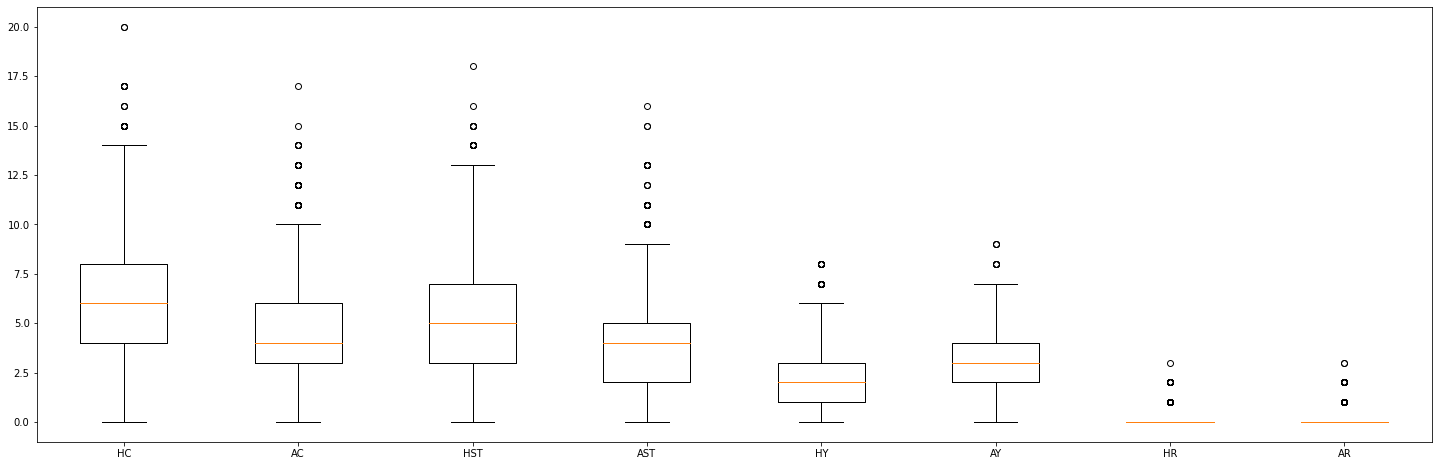

In [221]:
#boxplot
fig = plt.figure(figsize = (25,8))
labels = ["HC","AC","HST","AST","HY","AY","HR","AR" ]
plt.boxplot([dataset["HC"],dataset["AC"],dataset["HST"],dataset["AST"],dataset["HY"],dataset["AY"],dataset["HR"],dataset["AR"]],labels = labels)
plt.show()


In [222]:
robust_scaler = RobustScaler()
dataset[['HC','AC','HST','AST','HY','AY','HR','AR']] = robust_scaler.fit_transform(dataset[['HC','AC','HST','AST','HY','AY','HR','AR']])

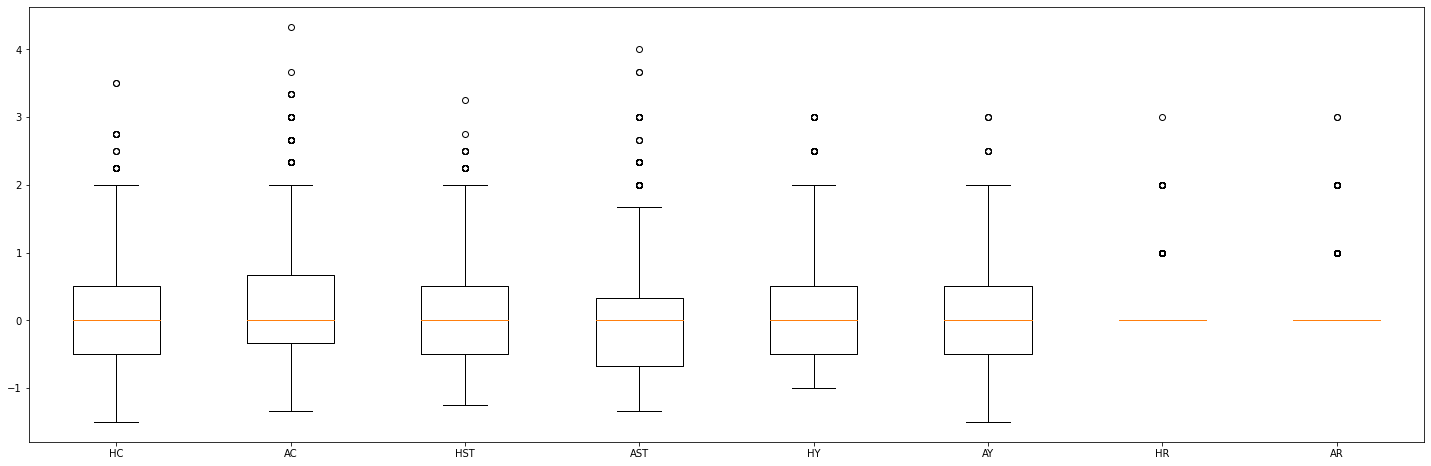

In [223]:
#after using the robustscaler, use the boxplot to check whether there is outliers
fig = plt.figure(figsize = (25,8))
labels = ["HC","AC","HST","AST","HY","AY","HR","AR" ]
plt.boxplot([dataset["HC"],dataset["AC"],dataset["HST"],dataset["AST"],dataset["HY"],dataset["AY"],dataset["HR"],dataset["AR"]],labels = labels)
plt.show()


In [224]:
#t = np.log(dataset["HR"] + 1) #make the data withou

In [225]:
dataset.head()

,HomeTeam,AwayTeam,whether_home_wins,HC,AC,HST,AST,HY,AY,HR,AR
0,Real Madrid,La Coruna,1,1.00,-0.333333,1.50,-0.333333,0.0,-0.5,0.0,0.0
1,Zaragoza,Tenerife,1,0.25,1.333333,0.75,-0.666667,-0.5,0.5,0.0,0.0
2,Almeria,Valladolid,0,1.50,-0.666667,0.00,-1.000000,0.0,-0.5,0.0,1.0
3,Ath Bilbao,Espanol,1,0.00,-0.333333,-0.25,-1.000000,0.0,1.5,0.0,0.0
4,Malaga,Ath Madrid,1,-0.50,0.333333,-0.25,-0.333333,1.0,0.5,0.0,0.0


In [226]:
dataset = pd.get_dummies(dataset, columns=['HomeTeam','AwayTeam'], 
                        #dummy_na=True, 
                        drop_first=True)#onehot encodiing

In [227]:
dataset.head()

,whether_home_wins,HC,AC,HST,AST,HY,AY,HR,AR,HomeTeam_Almeria,...,AwayTeam_Sevilla,AwayTeam_Sociedad,AwayTeam_Sp Gijon,AwayTeam_Tenerife,AwayTeam_Valencia,AwayTeam_Valladolid,AwayTeam_Vallecano,AwayTeam_Villarreal,AwayTeam_Xerez,AwayTeam_Zaragoza
0,1,1.00,-0.333333,1.50,-0.333333,0.0,-0.5,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.25,1.333333,0.75,-0.666667,-0.5,0.5,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1.50,-0.666667,0.00,-1.000000,0.0,-0.5,0.0,1.0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,0.00,-0.333333,-0.25,-1.000000,0.0,1.5,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,-0.50,0.333333,-0.25,-0.333333,1.0,0.5,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
X = dataset.drop(columns=['whether_home_wins'])
y = dataset.loc[:,'whether_home_wins']

In [229]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2, stratify = y)

Logistic Regression (Choose C)

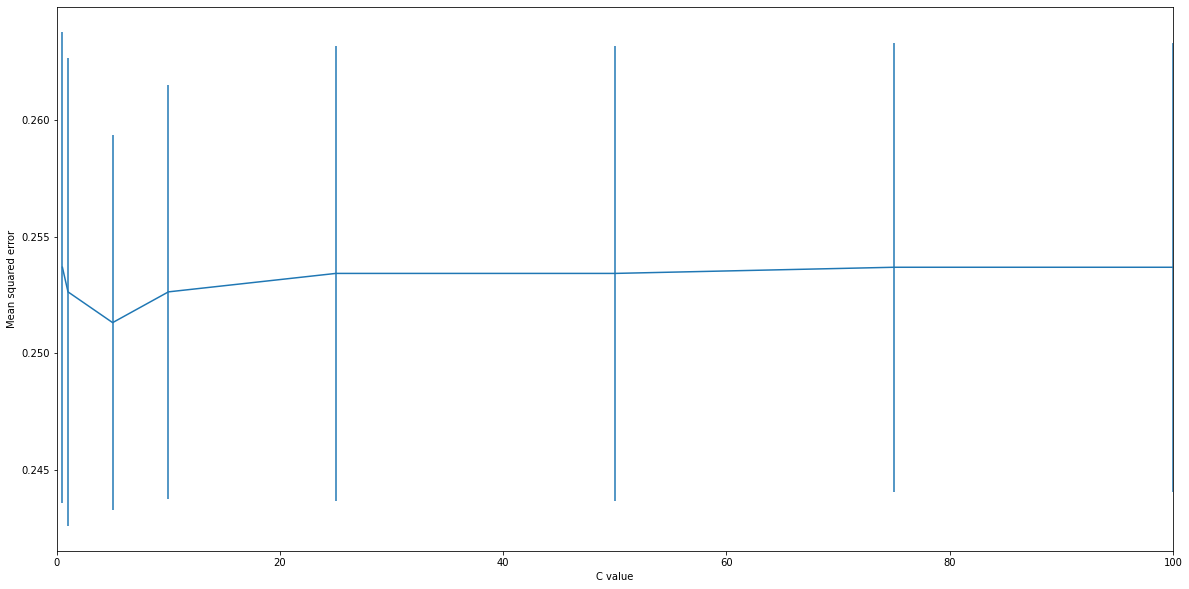

In [230]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def LogisticRegression_C():
#     set a raneg for the value of C
  C_range = [0.5, 1, 5, 10, 25, 50, 75, 100]

  mean_error=[]
  std_error=[]
  for Ci in C_range:

    model = LogisticRegression(penalty = 'l2', C = Ci)
    temp = []
#   use cross validation to calculate the MSE
    kf = KFold(n_splits = 5)
    for train,test in kf.split(X):
      model.fit(np.array(X)[train], np.array(y)[train])
      ypred = model.predict(np.array(X)[test])
      temp.append(mean_squared_error(y[test], ypred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
# plot the MSE with various C
  fig = plt.figure(figsize = (20, 10))
  plt.errorbar(C_range, mean_error, yerr = std_error)
  plt.xlabel('C value')
  plt.ylabel('Mean squared error')
  plt.xlim((0,100))
  plt.show()
    
LogisticRegression_C()

Logistic Regression with C = 5

In [231]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(penalty = 'l2', C = 5)
classifier_LR.fit(X_train, y_train)

LogisticRegression(C=5)

In [232]:
y_pred_lr = classifier_LR.predict(X_test)

In [233]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred_lr)

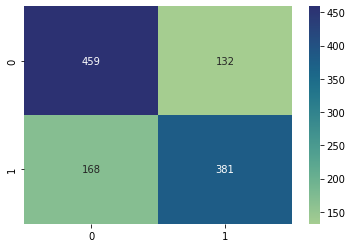

In [234]:
sns.heatmap(cm, annot=True,fmt='d',cmap="crest")
plt.show()

In [235]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       591
           1       0.74      0.69      0.72       549

    accuracy                           0.74      1140
   macro avg       0.74      0.74      0.74      1140
weighted avg       0.74      0.74      0.74      1140



SVM (Choose C)

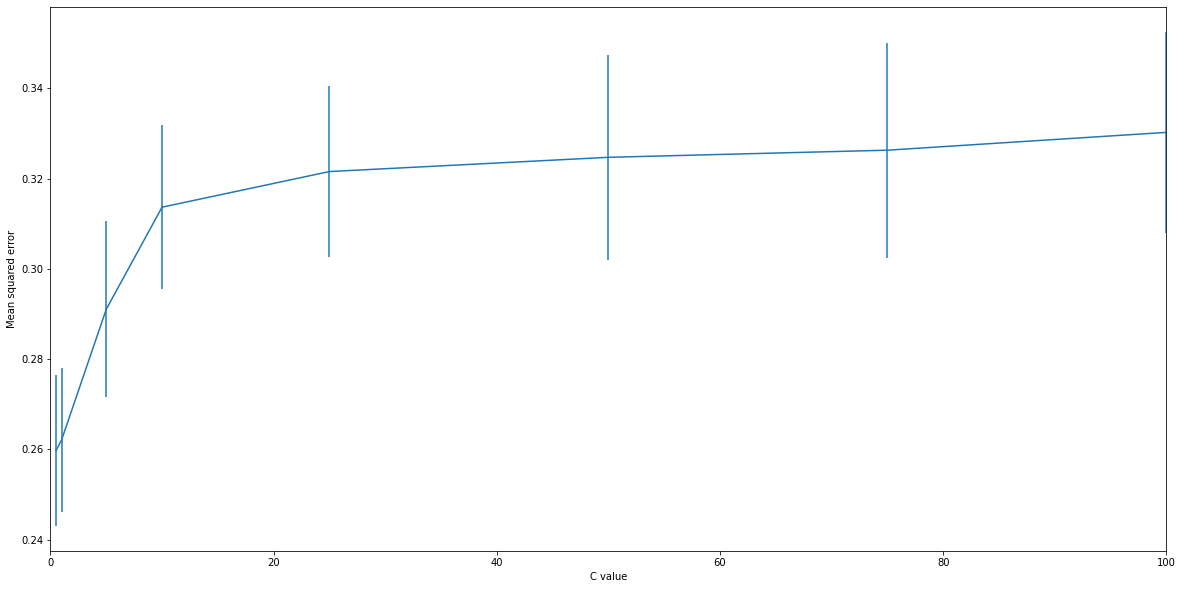

In [236]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def SVM_C():
#     set a raneg for the value of C
  C_range = [0.5, 1, 5, 10, 25, 50, 75, 100]

  mean_error=[]
  std_error=[]
  for Ci in C_range:
    # svm.SVC(probability=True)
    model = svm.SVC(probability=True, C = Ci)
    temp = []
#   use cross validation to calculate the MSE
    kf = KFold(n_splits = 5)
    for train,test in kf.split(X):
      model.fit(np.array(X)[train], np.array(y)[train])
      ypred = model.predict(np.array(X)[test])
      temp.append(mean_squared_error(y[test], ypred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
# plot the MSE with various C
  fig = plt.figure(figsize = (20,10))
  plt.errorbar(C_range, mean_error, yerr = std_error)
  plt.xlabel('C value')
  plt.ylabel('Mean squared error')
  plt.xlim((0,100))
  plt.show()
    
SVM_C()

SVM with C = 10

In [237]:
# Fitting Logistic Regression to the Training set
from sklearn.svm import LinearSVC
classifier_SVM = svm.SVC(probability=True, C = 10)
classifier_SVM.fit(X_train, y_train)

SVC(C=10, probability=True)

In [238]:
y_pred_svm = classifier_SVM.predict(X_test)

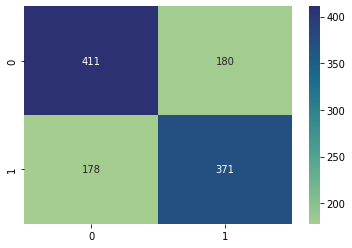

In [239]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt = 'd',cmap="crest")

In [240]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       591
           1       0.67      0.68      0.67       549

    accuracy                           0.69      1140
   macro avg       0.69      0.69      0.69      1140
weighted avg       0.69      0.69      0.69      1140



Random Forest (Choose Max Depth)

In [241]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import svm


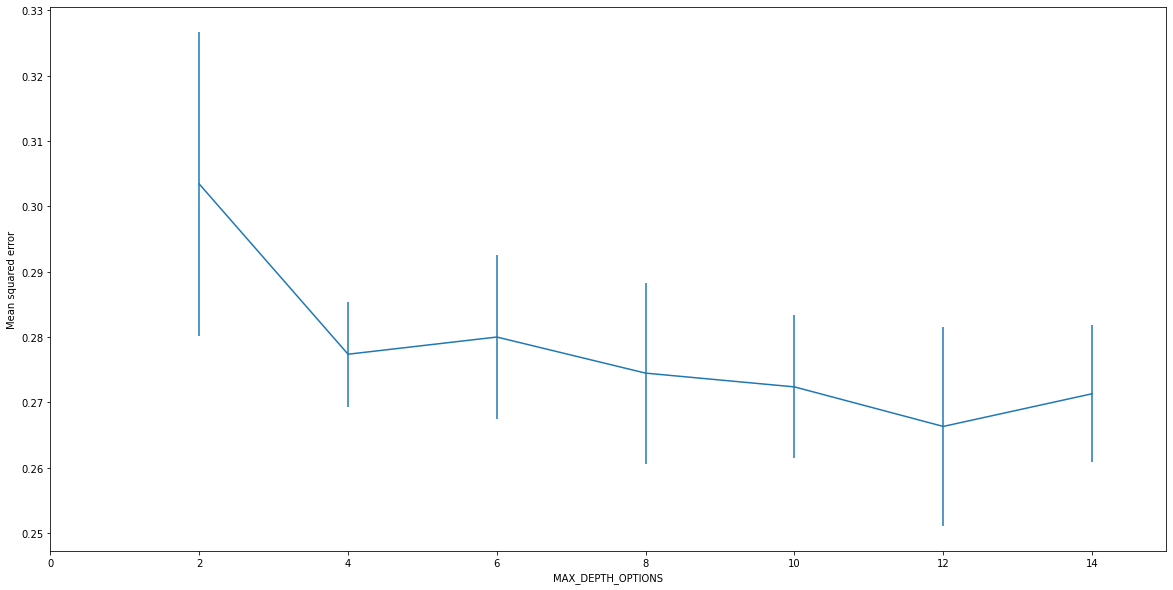

In [242]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
def RF_Max_Depth():
#     set a raneg for the value of max depth
  MAX_DEPTH_OPTIONS = [2, 4, 6, 8, 10, 12, 14]

  mean_error=[]
  std_error=[]
  for md_i in MAX_DEPTH_OPTIONS:
    # svm.SVC(probability=True)
    model = RandomForestClassifier(max_depth = md_i)
    temp = []
#   use cross validation to calculate the MSE
    kf = KFold(n_splits = 5)
    for train,test in kf.split(X):
      model.fit(np.array(X)[train], np.array(y)[train])
      ypred = model.predict(np.array(X)[test])
      temp.append(mean_squared_error(y[test], ypred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
# plot the MSE with various max depths
  fig = plt.figure(figsize = (20, 10))
  plt.errorbar(MAX_DEPTH_OPTIONS, mean_error, yerr = std_error)
  plt.xlabel('MAX_DEPTH_OPTIONS')
  plt.ylabel('Mean squared error')
  plt.xlim((0,15))
  plt.show()
    
RF_Max_Depth()

Random Forest with max depth = 12

In [243]:
classifier_RF = RandomForestClassifier(max_depth = 12)
classifier_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=12)

In [244]:
y_pred_rf = classifier_RF.predict(X_test)

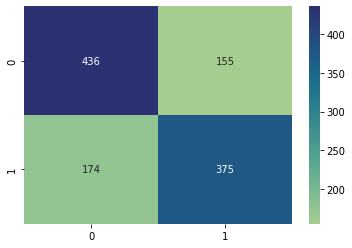

In [245]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d',cmap="crest")
plt.show()

In [246]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       591
           1       0.71      0.68      0.70       549

    accuracy                           0.71      1140
   macro avg       0.71      0.71      0.71      1140
weighted avg       0.71      0.71      0.71      1140



KNN

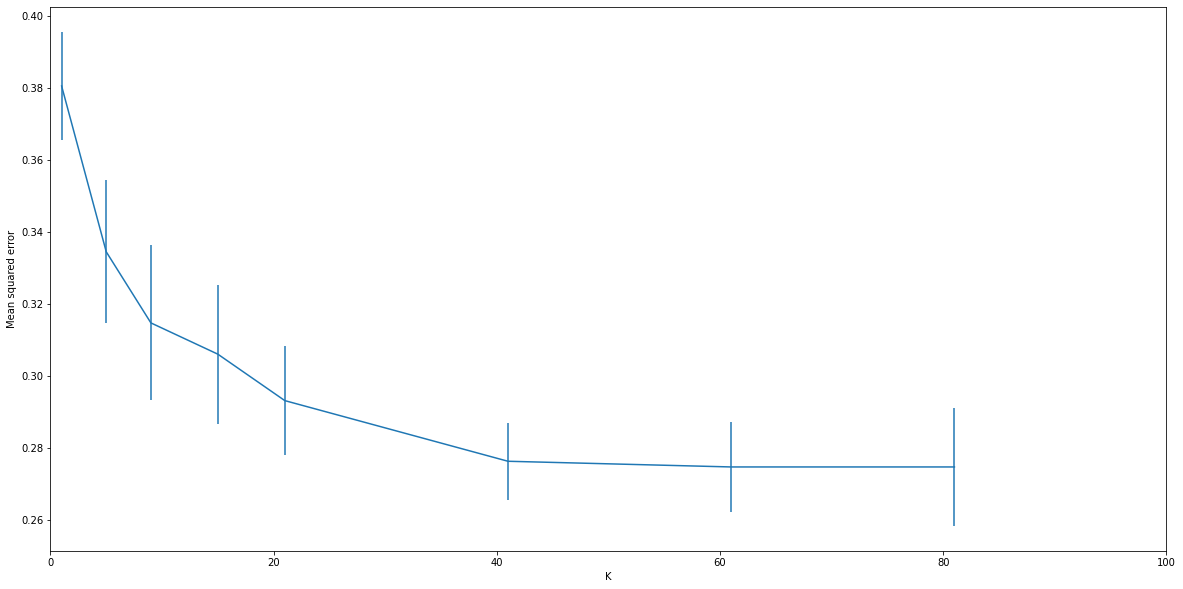

In [247]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


def KNN():
#     set a range for k
    K_range = [1, 5, 9, 15, 21, 41, 61, 81]
    mean_error = []
    std_error = []
    for Ki in K_range:
        knn = KNeighborsClassifier(n_neighbors = Ki)
        temp = []
#         use 5-folds cross validation
        kf = KFold(n_splits = 5)
        for train, test in kf.split(X):
            knn.fit(np.array(X)[train], np.array(y)[train])
            ypred = knn.predict(np.array(X)[test])
            temp.append(mean_squared_error(y[test], ypred))
        mean_error.append(np.array(temp).mean())
        std_error.append(np.array(temp).std())
        y_pred_proba = knn.predict_proba(X_test)[:,1]

# plot the MSE
    fig = plt.figure(figsize = (20, 10))
    plt.errorbar(K_range, mean_error, yerr = std_error)
    plt.xlabel('K')
    plt.ylabel('Mean squared error')
    plt.xlim((0,100))
    plt.show()

KNN()

KNN with K = 61

In [248]:
classifier_KNN = KNeighborsClassifier(n_neighbors = 61)
classifier_KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=61)

In [249]:
y_pred_knn = classifier_KNN.predict(X_test)

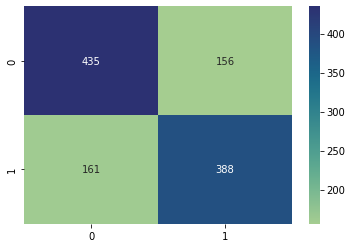

In [250]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot = True, fmt = 'd',cmap="crest") 

In [251]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       591
           1       0.71      0.71      0.71       549

    accuracy                           0.72      1140
   macro avg       0.72      0.72      0.72      1140
weighted avg       0.72      0.72      0.72      1140



Baseline Model

In [252]:
from sklearn.dummy import DummyClassifier
classifier_Baseline = DummyClassifier(strategy = "most_frequent")
classifier_Baseline.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [253]:
y_pred_baseline = classifier_Baseline.predict(X_test)

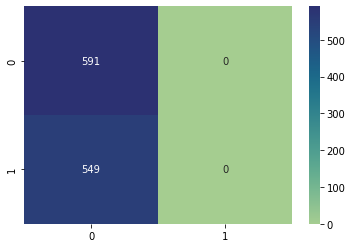

In [254]:
cm = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm, annot = True, fmt = 'd',cmap="crest") 
plt.show()

In [255]:
print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       591
           1       0.00      0.00      0.00       549

    accuracy                           0.52      1140
   macro avg       0.26      0.50      0.34      1140
weighted avg       0.27      0.52      0.35      1140



ROC Curves

In [256]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
def evaluate_model(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy =accuracy_score(y_test, _predicted_values)    # compute accuracy
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])    # compute precision, recall and f1 score for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)    
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])  
    _auc = auc(_fpr, _tpr)   # compute the area under the curve according the aoc diagram   
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [257]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test,y_test, classifier_SVM)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test,y_test, classifier_RF)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test,y_test, classifier_KNN)
LR_accuracy, LR_precision, LR_recall, LR_f1_score, LR_tpr, LR_auc = evaluate_model(X_test,y_test, classifier_LR)

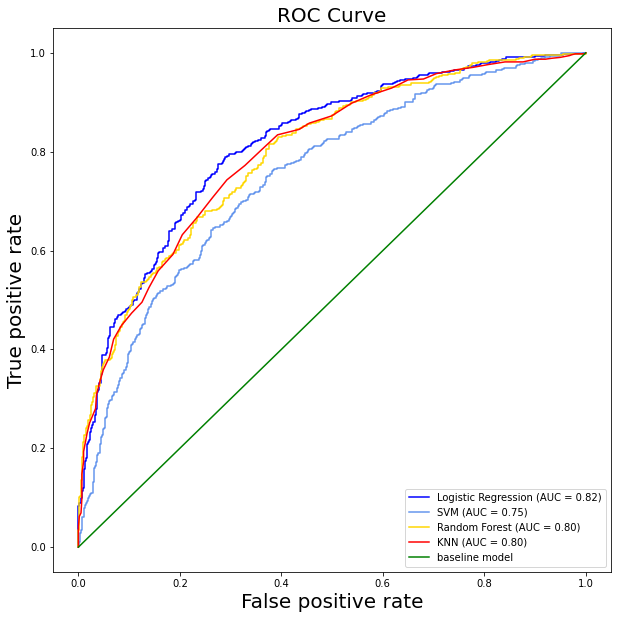

In [258]:
def ROC():
    figure = plt.figure(figsize = (10,10))
    # Logistic Regression Classifier
    model_lr = LogisticRegression(penalty = 'l2', C = 5)
    model_lr.fit(X_train, y_train)
    pred_lr = model_lr.decision_function(X_test)
    fpr, tpr, _= roc_curve(y_test, pred_lr)
    plt.plot(fpr,tpr, color = 'b', label='Logistic Regression (AUC = %0.2f)' % (LR_auc))

    # SVM Classifier
    model_svm = svm.SVC(probability=True, C = 10)
    model_svm.fit(X_train, y_train)
    pred_svm = model_svm.decision_function(X_test)
    fpr, tpr, _= roc_curve(y_test, pred_svm)
    plt.plot(fpr,tpr, color = '#6495ED', label='SVM (AUC = %0.2f)' % (SVM_auc))

    # Random Forest Classifier
    model_rf = RandomForestClassifier(max_depth = 12)
    model_rf.fit(X_train, y_train)
    pred_rf = model_rf.predict_proba(X_test)
    fpr, tpr, _= roc_curve(y_test, pred_rf[:, 1])
    plt.plot(fpr,tpr, color = '#FFD700', label='Random Forest (AUC = %0.2f)' % (RF_auc))

    # kNN Classifier
    model_knn = KNeighborsClassifier(n_neighbors = 61)
    model_knn.fit(X_train, y_train)
    pred_knn = model_knn.predict_proba(X_test)
    fpr, tpr, _= roc_curve(y_test, pred_knn[:, 1])
    plt.plot(fpr, tpr, color = 'r', label='KNN (AUC = %0.2f)' % (KNN_auc))

    # Baseline Classifier
    model_bc = DummyClassifier(strategy = "most_frequent")
    model_bc.fit(X_train, y_train)
    pred_bc = model_bc.predict_proba(X_test)
    fpr, tpr, _= roc_curve(y_test, pred_bc[:, 1])
    
    plt.plot(fpr, tpr, color = 'g', label = 'baseline model')
    
# plot the ROC curves
    
    plt.xlabel('False positive rate', fontsize=20)
    plt.ylabel('True positive rate', fontsize=20)
    plt.title('ROC Curve', fontsize=20)
    plt.legend(loc="lower right")

    #plt.legend(['Logistic Regression', 'Random Forest', 'SVM',  'kNN', 'Baseline'])
    plt.show()    

ROC()

Comparison

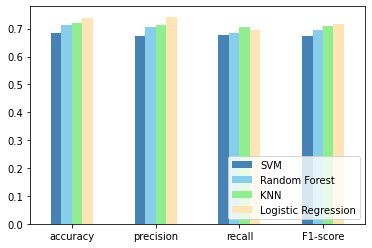

In [259]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
LR_metrics = np.array([LR_accuracy, LR_precision, LR_recall, LR_f1_score])


index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN':KNN_metrics,'Logistic Regression':LR_metrics}, index=index)
df_metrics.plot.bar(rot=0,color={"SVM": "#4682B4", "Random Forest": "#87CEEB","KNN": "#90EE90","Logistic Regression": "#FFE4B5" })
plt.legend(loc="lower right")
plt.show()